# Dense Neural Network
A dense NN is also called a Fully Connected (FC) or Multi-Layer Perceptron (MLP).   

## Architecture
The network consists of layers which consist of neurons.

### Layers:    
The neural network architecture is: 
* Input Layer that reads features 
* Internal Layer(s) that have trainable weights 
* Output Layer that produces scores.

The input layer should have one neuron per feature of the input vector.
The output layer should have one neuron per label that needs to be predicted.
A deep NN has many internal layers.

### Neurons:    
Each layer consists of Neurons.
Neurons consist of Weighted Inputs | Summation | Activation Function | Output.
With non-linear activations, 
the network can in theory discover any non-linear decision boundary.

Each neuron has one extra weighted input called the bias.
The bias is merely for scaling the output, 
equivalent to the y-intercept b in the linear equation y=mx+b.

### MLP:    
In the MLP architecture, also called fully-connected, 
neurons have no connections to other neurons in the same layer,
but they are connected to every neuron in the layers immediately before and after.



## Training
### Trainable parameters:  
The model as trainable weights on every edge.
The weights are initialized randomly. 
(The Keras default is the Xavier or Glorot Uniform algorithm).

### One forward calculation:  
The model is shown one data instance from the labeled training set.
Using the weights and activations, the output scores are computed.

### One back propagation:   
For the labeled training instance, the true scores are known.
A loss function is applied to the actual-score deviation from true.
The partial derivative of the loss, with respect to each input, provides a gradient.
The gradient tells the amount and direction that each input contributed to the loss.
Using partial derivatives of the activations,
the total loss is distributed, such that every neuron accepts some portion of the loss. 
Finally, the weight of each neuron's output is updated
in the opposite direction of the gradient, so as to reduce the loss.
The size of the update can be controlled by a learn rate parameter.

### Gradient descent:   
The back propagation can apply to the loss over any number of instances, called a batch.
If the batch size is 1, and each next training instance is chosen randomly,
that is called "stochastic gradient descent."
If the batch size equals the whole training set,
that is called "batch gradient descent" but it is computationally prohibitive.
In keras, the default batch size is 32, 
and instances within each batch are used in random order.

### Epoch:   
When all the training samples have been used once, the model has been trained for one epoch.
It is usually necessary to train a model for many epochs.

## Evaluation
### Validiation cycles:   
We train a model on a training set.
We evaluate the model on a separate validation set.
In cycles, we adjust the model architecture and hyperparameters
until the validation accuracy looks good.
Finally, when we are happy with our model,
we measure accuracy of the trained model on the test data,
which has not been used so far.
With luck, this number predicts model accuracy on future unseen data.

### Test set:   
Some portion of the data, maybe 20%, is set aside for post-training evaluation.
It is very important to avoid looking within the test set.
Otherwise, the model accuracy could be artificially and inadvertently inflated.

### Validation set:   
Some portion of the remaining data, maybe 20%, is set aside for hyperparameter tuning.
For instance, should the deep neural network have 10 layers or 20?
The model gets trained and evaluated and then tuned in cycles.
It is important to avoid using any validation data for training, and vice-versa.
Otherwise, the validation accuracy could be inflated.

### Training set:   
After removing the test and validation data, the training set is what remains.

### Cross validation:   
This is used to alleviate a data shortage,
when we would rather not have to set aside a validation set.
In 5-fold cross-validation, we make 5 mutually exclusive partions,
of 80% train and 20% valid. 
Use sampling without replacement, 
so each data instaince will be used 4 times for training and 1 time for validation.
The total validation accuracy is the mean of 5 rounds of training & validation.
After model tuning is complete, the full dataset is used to retrain the model.
The model thus trained is then evaluated on the previously-unseen test set.

If you report cross-validation accuracy without a separate test set,
you cannot be sure the model generalizes to unseen data.

In [1]:
import datetime
print(datetime.datetime.now())
from platform import python_version
print('Python',python_version())
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2022-09-05 18:39:38.116418
Python 3.10.0


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import StratifiedKFold

## The Dataset
Iris:   
We'll use the Iris dataset,
famous because it was used in a regression paper by R.A. Fisher.
There are 150 data instances, each a flower with 4 numeric features.
Each instance is one of 3 species, labled 0, 1, 2.

Shuffle:  
The data are provided in order (0s first, 2s last).
We must avoid training on 0s and testing on 2s, so we shuffle the rows.
In our experiments on this page, the shuffle step was critical.

In [3]:
from sklearn import datasets
from sklearn.utils import shuffle
iris = datasets.load_iris()
print('shape',iris.data.shape)
print('features',iris.feature_names)
print('labels',iris.target_names)
X = iris.data
y = iris.target
# At start, all species=0 come first and all species=2 come last.
# Important to shuffle rows before doing train/test split and train/valid split.
# Another way is using the sklearn train_test_split class.
X, y = shuffle(X, y)   # add this for reproducible results: random_state=0
print('X shape',X.shape)
print('y shape',y.shape)
num_instances = X.shape[0]
num_features =  X.shape[1]
num_labels = len(np.unique(y))

shape (150, 4)
features ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
labels ['setosa' 'versicolor' 'virginica']
X shape (150, 4)
y shape (150,)


### Set aside the test set
In preparation for the final test, we set aside 10% of the data as unseen.
Since the rows were previously shuffled, the last 10% is a random subset.

In [4]:
UNSEEN_PORTION = 0.10
split_point = int ( X.shape[0] * (1-UNSEEN_PORTION) )
# Tensors don't support slice. Use numpy array here, tensor later.
X_unseen = np.array(X)[split_point:]
y_unseen = np.array(y)[split_point:]
X_seen   = np.array(X)[:split_point]
y_seen   = np.array(y)[:split_point]

In [5]:
# Here are the species labels. Each y corresponds to a row of X_seen.
y_seen[:10]

array([0, 2, 0, 2, 2, 2, 1, 1, 2, 0])

In [6]:
# Here is the raw data, row-shuffled but not normalized.
X_seen[:10]

array([[5.1, 3.8, 1.6, 0.2],
       [6.4, 3.1, 5.5, 1.8],
       [4.7, 3.2, 1.6, 0.2],
       [6.7, 3. , 5.2, 2.3],
       [7.7, 2.8, 6.7, 2. ],
       [6.5, 3. , 5.8, 2.2],
       [5.5, 2.3, 4. , 1.3],
       [5. , 2. , 3.5, 1. ],
       [7.7, 3. , 6.1, 2.3],
       [5.4, 3.9, 1.7, 0.4]])

### Normalization
Without normalization, the feature with biggest variance dominates.  
We use the Keras Normalization class:
1. Constructor takes axis, mean, var. By default, axis = -1 (the last axis), mean=0, var=1.
1. The adapt() method tunes the scaling parameters to the given data.
1. From then on, the object scales any given data.
1. Importantly, we adapt() to the training data and apply to the test data.

In [7]:
# Unintented side effect: the numpy arrays get converted back to tensors.
normalizer = layers.Normalization() 
normalizer.adapt(X_seen)   # adapt to the training data only
X_seen = normalizer(X_seen)
X_unseen = normalizer(X_unseen)
# Here are the normalized feature values.
X_seen[:10]

2022-09-05 18:39:49.619531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[-0.9152527 ,  1.6794697 , -1.2353383 , -1.3191453 ],
       [ 0.6830248 ,  0.09869362,  0.98675144,  0.7805996 ],
       [-1.4070305 ,  0.32451907, -1.2353383 , -1.3191453 ],
       [ 1.0518577 , -0.12713131,  0.81582135,  1.43677   ],
       [ 2.2813017 , -0.5787817 ,  1.6704712 ,  1.0430678 ],
       [ 0.80596906, -0.12713131,  1.1576816 ,  1.305536  ],
       [-0.42347497, -1.7079074 ,  0.13210155,  0.12442929],
       [-1.038197  , -2.3853827 , -0.15278174, -0.26927283],
       [ 2.2813017 , -0.12713131,  1.3286114 ,  1.43677   ],
       [-0.54641926,  1.9052951 , -1.1783615 , -1.0566772 ]],
      dtype=float32)>

## Model Architecture
Here we decide number of layers, number of neurons per layer, and activation functions.
Deciding this is an artform. 
In fact, we played with several settings before settling on the ones shown here. 

Keras offers 2 means of building a model.
Both use [model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).  
1. The [Sequential class](https://keras.io/api/models/sequential/#sequential-class) is simple. It has an add(layer) method. It maintains layers in the order they were added. It allows linear models only. Every layer has one input and one output.
1. The [Functional API](https://keras.io/guides/functional_api/) is complex. It allows DAG models. Layers can be skipped, reused, and multiply connected. We use the Functional API even though our model is linear in this example.

The Keras Dense layer class has these constructor options.
1. num units
1. activation. Default=linear. Choices are relu, elu, softplus (smooth relu), softmax, sigmoid, tanh, exponential. There is an API so you can build your own.
1. use_bias. Default=True
1. kernel_initializer. Default="glorot_uniform"
1. regularizers for the bias, kernel, and activity. Default=None.

Input layer:       
Our input layer has the same shape as the features: 1x4.
We don't specify the shape's number of rows because that varies between validation & testing.

Dense layers:   
Our model will have 2 dense layers with 8 neurons each.
The activation is relu() which is regarded as better than sigmoid() and tanh()
for supporting quick training and avoiding the vanishing/exploding gradient. 

Dropout layer:    
Between dense layers is a dropout layer.
Dropout was invented by Hinton to force the model to generalize.
A different random portion of neurons will drop out of each training epoch.
Thus, the model won't be able to rely on any one neuron to always fire, 
even on the same input.
(Tensorflow predict() and evaluate() disable dropout,
so the model uses all its neurons for prediction, no matter how it was trained.)

Output layer:   
Our output layer has the same shape as the labels: 3x1.
Each label is an integer 0, 1, or 2.
(Alternately, we could use shape 1x3 and one-hot encoding.
However, Tensorflow now supports integer labels.)
The activation is softmax() which generates
a sigmoid-like probability for each of the three possible labels.

Loss:   
We use cross entropy loss to encourage the model to give one-of-three
labels a high score for each training instance.
Tensorflow's categorical_crossentropy() requires one-hot encoding.
Tensorflow's SparseCategoricalCrossentropy requires integer labels, which we have.

Optimizer:    
The optimizer determines update sensitivity to the latest gradient. 
Tensorflow provides a variety of optimizers, each an implementation of a published algorithm.
We tried only two (Adam and RMSprop) and detected no difference.
To me, RMSprop seems similar to using moving average with exponential smoothing. 

Overall:    
This is a very small neural network designed for this demonstration only.

In [8]:
def make_model(name):
    # Keras output layer raises exception unless #neurons == #labels in Y.
    DROPOUT = 0.20
    NEURONS = 8
    inputs  =  keras.Input(shape=(num_features,))
    prev    =  inputs
    prev    =  layers.Dense(NEURONS, activation="relu")       (prev)
    prev    =  layers.Dropout(DROPOUT)                        (prev)
    prev    =  layers.Dense(NEURONS, activation="relu")       (prev)
    outputs =  layers.Dense(num_labels, activation="softmax") (prev)
    new_model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    #loss='categorical_crossentropy',optimizer='adam',
    #loss=keras.losses.SparseCategoricalCrossentropy(),optimizer=keras.optimizers.RMSprop(),
    new_model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.RMSprop(),
        metrics=["accuracy"])
    return new_model

## Count the trainable parameters
Here we explain the number of trainable parameters that are shown below.
1. Dense_0: (4 input + 1 bias) * 8 neurons = 40 
1. Dense_1: (8 input + 1 bias) * 8 neurons = 72 
1. Dense_2: (8 input + 1 bias) * 3 neurons = 27

In [9]:
demo = make_model("Demo")
demo.summary()

Model: "Demo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 8)                 40        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________


## Training and Validation
We use the process documented at [Keras models](https://keras.io/api/models/).

Train:    
This is implemented by the Keras model.fit() function.
We call it 5 times in a loop.
We give it the training data and the validation data.
For training, it uses the training data exclusively.
For validation, it uses the validation data exclusively.
So, for example, dropout regularization 
is applied to learning from the training data 
but not to evaluating on the validation data.

Validate:    
This is implemented by the Keras model.evaluate() function.
We call it once for each call to model.fit().

Cross Validation:   
We evaluate the model by 5-fold cross validation.
We use "stratified" KFold so that each validation set
has approximately the same number of each label (flower species).

In 5 iterations of the loop, we will:    
1. Re-build the model. Otherwise each loop would additively improve the same model. Can you guess how I figured that out?
2. Fit the model to the training data by adjusting parameters. In Keras, model.fit() is made to be customized, but we use it as is. Thanks to the default shuffle=True, model.fit() 
shuffles each batch before training on it. 
3. Evaluate the model on the validation data. This is much faster than training. Using the forward computation only, we compute a score for each validation instance.

In [10]:
# Use seen data only. Do not peek at unseen data.
EPOCHS=40
SPLITS=5
fold=0
skf = StratifiedKFold(n_splits=SPLITS)
history_vector=[None]*SPLITS
valid_vector  =[None]*SPLITS
def tensor_slice(tensor,index):
    array = np.array(tensor)
    subset = array[index]
    tensor = tf.convert_to_tensor(subset)
    return tensor
for train, valid in skf.split(X_seen,y_seen):
    X_train = tensor_slice(X_seen,train)
    y_train = tensor_slice(y_seen,train)
    X_valid = tensor_slice(X_seen,valid)
    y_valid = tensor_slice(y_seen,valid)
    validata = (X_valid,y_valid)
    name = "MLP_"+str(fold)
    fold_model  = make_model(name)
    fold_history = fold_model.fit(X_train,y_train,
                                  batch_size=25,epochs=EPOCHS,validation_data=validata)
    # The call to evaluate() is redundant with fit(validation_data),
    # but it provides a quick & easy way to get the final validation scores.
    fold_valid = None
    fold_valid = fold_model.evaluate(X_valid, y_valid)
    history_vector[fold]=fold_history
    valid_vector  [fold]=fold_valid
    fold += 1
    print("Fold", fold,"Valid accuracy:",fold_valid[1],"Valid loss:", fold_valid[0])

Epoch 1/40
5/5 [==============================] - 1s 47ms/step - loss: 1.0524 - accuracy: 0.3148 - val_loss: 0.9558 - val_accuracy: 0.3704
Epoch 2/40
5/5 [==============================] - 0s 14ms/step - loss: 1.0300 - accuracy: 0.3426 - val_loss: 0.9270 - val_accuracy: 0.3704
Epoch 3/40
5/5 [==============================] - 0s 12ms/step - loss: 1.0037 - accuracy: 0.3333 - val_loss: 0.9069 - val_accuracy: 0.4074
Epoch 4/40
5/5 [==============================] - 0s 10ms/step - loss: 0.9582 - accuracy: 0.3241 - val_loss: 0.8858 - val_accuracy: 0.3704
Epoch 5/40
5/5 [==============================] - 0s 14ms/step - loss: 0.9452 - accuracy: 0.3426 - val_loss: 0.8683 - val_accuracy: 0.3704
Epoch 6/40
5/5 [==============================] - 0s 8ms/step - loss: 0.9441 - accuracy: 0.3241 - val_loss: 0.8521 - val_accuracy: 0.3704
Epoch 7/40
5/5 [==============================] - 0s 9ms/step - loss: 0.9471 - accuracy: 0.3519 - val_loss: 0.8347 - val_accuracy: 0.3704
Epoch 8/40
5/5 [=============

Epoch 36/40
5/5 [==============================] - 0s 8ms/step - loss: 0.5476 - accuracy: 0.7870 - val_loss: 0.5116 - val_accuracy: 0.8148
Epoch 37/40
5/5 [==============================] - 0s 9ms/step - loss: 0.5178 - accuracy: 0.8241 - val_loss: 0.5039 - val_accuracy: 0.8519
Epoch 38/40
5/5 [==============================] - 0s 8ms/step - loss: 0.5119 - accuracy: 0.8333 - val_loss: 0.4954 - val_accuracy: 0.8519
Epoch 39/40
5/5 [==============================] - 0s 14ms/step - loss: 0.5258 - accuracy: 0.8056 - val_loss: 0.4868 - val_accuracy: 0.8889
Epoch 40/40
1/1 [==============================] - 0s 18ms/step - loss: 0.4782 - accuracy: 0.8889
Fold 3 Valid accuracy: 0.8888888955116272 Valid loss: 0.47819486260414124
Epoch 1/40
5/5 [==============================] - 1s 38ms/step - loss: 1.1277 - accuracy: 0.1944 - val_loss: 1.0611 - val_accuracy: 0.2593
Epoch 2/40
5/5 [==============================] - 0s 9ms/step - loss: 1.1023 - accuracy: 0.1944 - val_loss: 1.0357 - val_accuracy: 0

Epoch 13/40
5/5 [==============================] - 0s 8ms/step - loss: 1.0444 - accuracy: 0.2963 - val_loss: 1.0502 - val_accuracy: 0.2963
Epoch 14/40
5/5 [==============================] - 0s 8ms/step - loss: 1.0385 - accuracy: 0.2870 - val_loss: 1.0427 - val_accuracy: 0.3333
Epoch 15/40
5/5 [==============================] - 0s 8ms/step - loss: 1.0275 - accuracy: 0.3889 - val_loss: 1.0357 - val_accuracy: 0.3333
Epoch 16/40
5/5 [==============================] - 0s 9ms/step - loss: 1.0132 - accuracy: 0.4722 - val_loss: 1.0291 - val_accuracy: 0.4444
Epoch 17/40
5/5 [==============================] - 0s 7ms/step - loss: 1.0048 - accuracy: 0.4907 - val_loss: 1.0213 - val_accuracy: 0.4815
Epoch 18/40
5/5 [==============================] - 0s 9ms/step - loss: 1.0003 - accuracy: 0.6019 - val_loss: 1.0137 - val_accuracy: 0.6296
Epoch 19/40
5/5 [==============================] - 0s 7ms/step - loss: 1.0027 - accuracy: 0.6481 - val_loss: 1.0055 - val_accuracy: 0.7037
Epoch 20/40
5/5 [==========

## Summarize the training and validation 
Within each round of cross valication,
after each epoch,
we measured train accuracy, train loss, validation accuracy, validation loss.
Now they can be plotted over time.

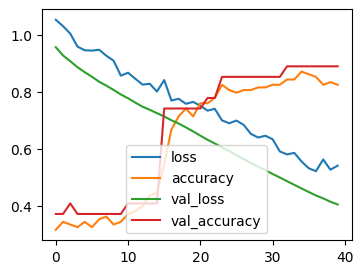

Fold 1 Final Validation acc = 0.89 loss =0.40


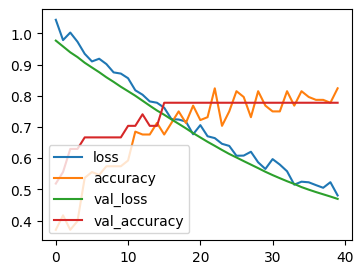

Fold 2 Final Validation acc = 0.78 loss =0.47


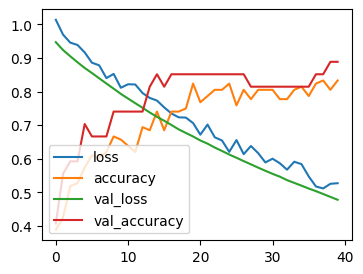

Fold 3 Final Validation acc = 0.89 loss =0.48


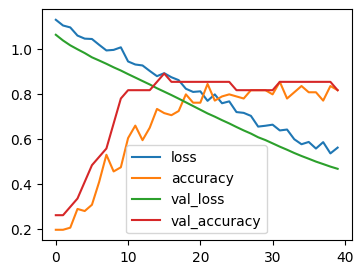

Fold 4 Final Validation acc = 0.81 loss =0.47


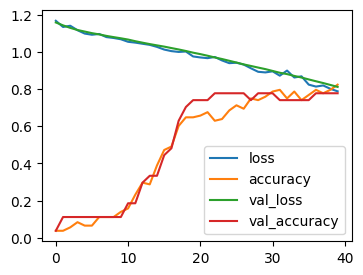

Fold 5 Final Validation acc = 0.78 loss =0.81


In [11]:
for fold in range(SPLITS):
    one_history = history_vector[fold]
    pair = valid_vector[fold]
    pd.DataFrame(one_history.history).plot(figsize=(4,3))
    plt.show()
    print('Fold %d Final Validation acc = %.2f loss =%.2f'%(fold+1,pair[1],pair[0]))

# Finally, compute test accuracy
Do this only after settling on the model hyperparameters once and for all.

Epoch 1/40
6/6 [==============================] - 1s 3ms/step - loss: 1.2453 - accuracy: 0.1778
Epoch 2/40
6/6 [==============================] - 0s 4ms/step - loss: 1.1989 - accuracy: 0.2370
Epoch 3/40
6/6 [==============================] - 0s 3ms/step - loss: 1.1765 - accuracy: 0.2519
Epoch 4/40
6/6 [==============================] - 0s 4ms/step - loss: 1.1516 - accuracy: 0.2815
Epoch 5/40
6/6 [==============================] - 0s 4ms/step - loss: 1.1212 - accuracy: 0.3259
Epoch 6/40
6/6 [==============================] - 0s 4ms/step - loss: 1.1136 - accuracy: 0.3185
Epoch 7/40
6/6 [==============================] - 0s 4ms/step - loss: 1.0973 - accuracy: 0.3481
Epoch 8/40
6/6 [==============================] - 0s 3ms/step - loss: 1.0851 - accuracy: 0.3778
Epoch 9/40
6/6 [==============================] - 0s 4ms/step - loss: 1.0596 - accuracy: 0.3704
Epoch 10/40
6/6 [==============================] - 0s 3ms/step - loss: 1.0378 - accuracy: 0.5333
Epoch 11/40
6/6 [======================

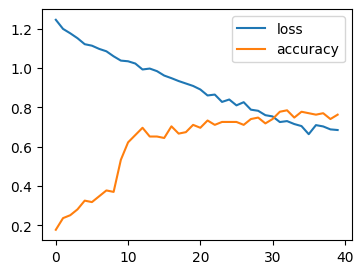

In [12]:
# Finally, we peek at the unseen data.
# Train a model on all the seen data previously used for in cross validation.
# Then test on unseen data for the first time.
final_model = None
X_train = X_seen  # don't need tf.convert_to_tensor()
y_train = y_seen
X_test  = X_unseen
y_test  = y_unseen
name = "MLP_final"
final_model   = make_model(name)
final_history = final_model.fit(X_train, y_train, batch_size=25, epochs=EPOCHS)
test_scores   = final_model.evaluate(X_test, y_test)
pd.DataFrame(final_history.history).plot(figsize=(4,3))
plt.show()

## Here is our final test accuracy:
High accuracy is not expected as we used a rather small neural network. 
Anything better than 33% is better than guessing.
Please note that the test set if very small, so the accuracy can vary widely between runs.
In fact, we've seen accuracy go from 60% to 100% just by re-running with a different random number seed.

In [13]:
print()
print('Test acc = %.2f loss = %.2f'%(test_scores[1],test_scores[0]))


Test acc = 0.87 loss = 0.62
